<a href="https://colab.research.google.com/github/riverdogcabin/PSDS4900/blob/main/wu_observation_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import arange
import scipy.stats as stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import seaborn as sns
from pprint import pprint
import json

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FactorAnalysis, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

In [ ]:
with open('/content/drive/MyDrive/Capstone/PSDS4900/config.json') as configuration:
  my_station = json.load(configuration).get('WU')["stationid"] #'WU' is the parameters for WeatherUnderground

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/PSDS4900/wu_data/wu_observations.csv')
df['timestamp'] = pd.to_datetime(df['epoch'], unit='s')
df = df.assign(timestamp_rounded=df.timestamp.dt.round('60min')) #rounded to the hour
print('with dupes',df.shape)
before = df.shape[0]
df.drop_duplicates(inplace=True)
print('without dupes',df.shape)
print('difference: ',before-df.shape[0])

with dupes (106143, 34)
without dupes (106143, 34)
difference:  0


### Helper function to grab the N most correlated stations from a big correlation matrix of all statiosn based on one variable (defaul windspeedAvg)

In [ ]:
def get_top_n_correlated(df,corr_df,num_stations=5,variable='windspeedAvg',my_station='KCOPARKE414'):
  target_stations = corr_df.sort_values(variable+'_corr',ascending=False).stationID.to_list()[:num_stations]
  target_stations.append(my_station)
  df_filtered = df[df.stationID.isin(target_stations)]
  df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=variable)
  before = df_reshaped.shape[0]
  df_reshaped.dropna(inplace=True)
  return df_reshaped, before-df_reshaped.shape[0]

### Clean up the spikes (dupes in each timegroup as outline din the stats notebook)

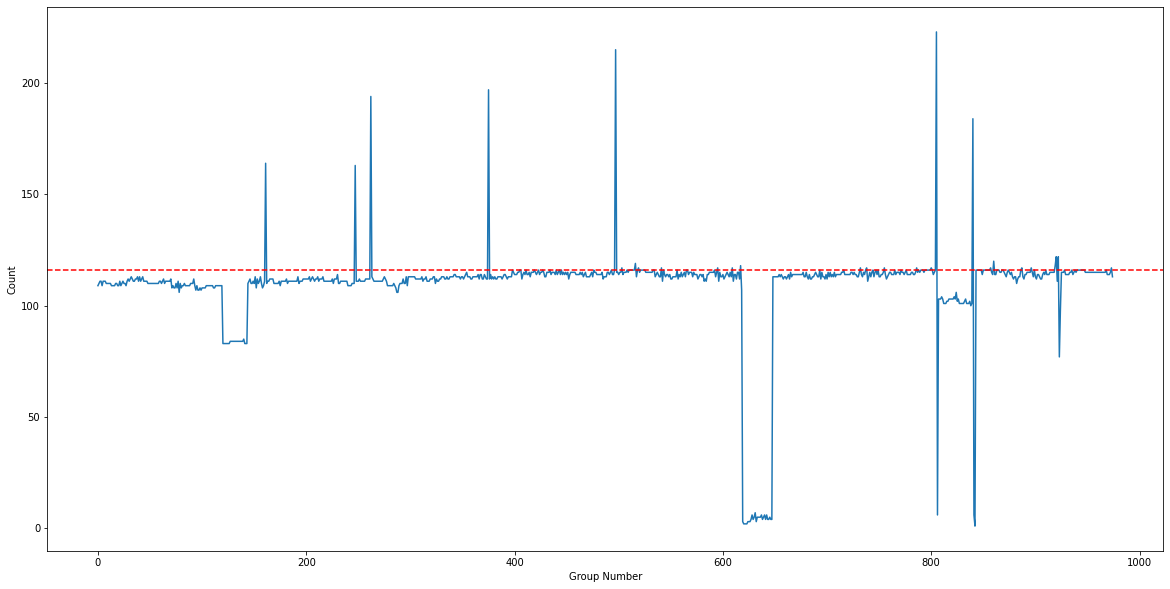

In [ ]:
num_stations = len(df.stationID.unique())
counted_df = df.groupby(['timestamp_rounded']).count().reset_index()
ax = counted_df.windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')
hour_grouping_std = counted_df.stationID.std()
# problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded) #get all groups that are more than one standard deviation off the station count
# indices_to_drop = df[(df.timestamp_rounded.isin(problem_hours)) & (df.timestamp > df.timestamp_rounded)].index
# df.drop(indices_to_drop,inplace=True)

In [ ]:
timestamp_target_dict = {}
timestamp_groups_to_remove = []
for tsr in set(df.timestamp_rounded):
  # print(tsr)
  target_timestamp = df[(df.stationID == my_station) & (df.timestamp_rounded == tsr)]
  # if(tsr == pd.to_datetime('2021-04-20 16:00:00')):
  #   print(target_timestamp)
  if(not target_timestamp.empty):
    timestamp_target_dict[tsr] = target_timestamp.loc[target_timestamp.timestamp.idxmax()].timestamp
  else:
    timestamp_groups_to_remove.append(tsr) #timestamp group does not contain my station
# timestamp_target_dict

In [ ]:
#get rid of timestamp groups that do not contain my station
df.drop(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index,inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
#create target_timestamp and use it to create the offsets so we can only keep observations closest to my_station
df['target_timestamp'] = df.timestamp_rounded.map(timestamp_target_dict)
df['offset'] = df.apply(lambda x: abs((x.timestamp-x.target_timestamp).total_seconds()),axis=1)

In [ ]:
bad_indices = []
problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded)

for hour in problem_hours:
  grouped = df[df.timestamp_rounded == hour].groupby('stationID')
  for group in grouped.groups:
    if(np.isnan(grouped.get_group(group).offset.idxmax())):
      print(group, hour)
    bad_indices.append(grouped.get_group(group).offset.idxmax())

bad_indices = bad_indices + list(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index)
# drop bad_indices and reset index
df.drop(bad_indices,inplace=True)
df.reset_index(inplace=True, drop=True)
print("Dropped {} rows".format(len(bad_indices)))

Dropped 674 rows


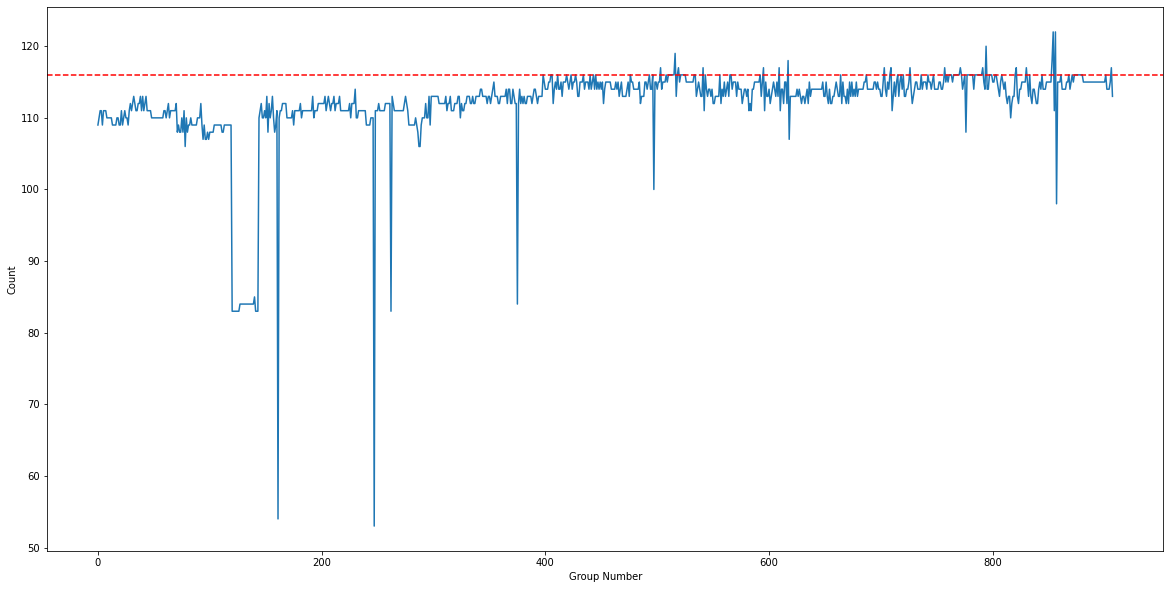

In [ ]:
## uncomment the below to check to make sure the spikes are gone
grouped = df.groupby(['timestamp_rounded'])
ax = grouped.count().reset_index().windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')

In [ ]:
#Quick check just within the data from my_station to see which data are most highly correlated with windspeedAvg
df[df.stationID == my_station].corr()[['windspeedAvg']].sort_values(by='windspeedAvg', ascending=False)

,windspeedAvg
windspeedAvg,1.000000
windgustAvg,0.994790
windspeedHigh,0.866358
windgustHigh,0.848006
windgustLow,0.545211
windspeedLow,0.481196
solarRadiationHigh,0.409138
uvHigh,0.403120
heatindexLow,0.381757
tempLow,0.380555


### Build correlation DataFrame and the dict of maximally correlated stations

In [ ]:
columns_to_check = [s for s in df.columns if "Avg" in s]
corr_df = pd.DataFrame({'stationID':df.stationID.unique()}) #create the shell of the dataframe to store the correlations
max_correlations = {} #this will hold the maximally correlated stations for each variable
for v in columns_to_check:
  #create a pivot table for each variable
  temp_df = df.pivot_table(index='timestamp_rounded',columns='stationID',values=v).corr()[[my_station]]
  temp_df.columns.name = None #get rid of the column names and then collapse the indices, reindex and rename the columns
  temp_df = temp_df.stack().reset_index().drop(columns='level_1').rename(columns={0:v+'_corr'})
  #get rid of the results for my_station, obvs 
  temp_df = temp_df[temp_df.stationID != my_station]
  #collect the maximally correlated station for the variable
  max_correlations[v] = temp_df.loc[temp_df[v+'_corr'].abs().idxmax()]
  #add all the corrleations for this variable as a column to the big correlation dataframe
  corr_df = corr_df.merge(temp_df,on='stationID')

### Now let's build a simple linear regression model and test it. Found a [ great code snippet to set up k-fold cross validation](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5) and adapted it. We'll start by just using the most highly-correlated station to create the model.

In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=5)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.8221800935517651, 0.8181571702386634, 0.8471954493171315]


### Those scores aren't bad, but they aren't great. Let's see if adding more stations improves things. We'll take the top five most correlated stations.

In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=10)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.8203081790483853, 0.8227486034432169, 0.8631763027273534]


### Those got better by adding four more highly-correlated stations. Let's see what happens when we add all the stations.

In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=-1)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score)
print(scores)

[0.8507651948082173, 0.7431968121290363, 0.7849794716563746]


### That did *not* improve things. I think that we had to drop too many rows because of missing values. Even though the hourly grouping was the _best_ way to align the data, it still means we lose lots of rows because of missing values. 

In [ ]:
for i in range(1,11):
  df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=i)
  X = pd.DataFrame(df_reshaped.drop(columns=my_station))
  y = pd.DataFrame(df_reshaped[[my_station]]) #target
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
  #define cross-validation method to evaluate model
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

  #define model
  model = LassoCV(cv=cv, n_jobs=-1)
  # alphas=arange(0.01, 1.01, 0.01)
  #fit model
  # model.fit(X, y)

  #display lambda that produced the lowest test MSE
  # print(model.alpha_)

  scores = cross_val_score(model,X,np.array(y).ravel())
  print('{} features\nscores: {}'.format(i,scores))

1 features
scores: [0.58379748 0.74866626 0.42236417 0.37292509 0.71809071]
2 features
scores: [0.77828389 0.81317451 0.49870031 0.65874777 0.84934264]
3 features
scores: [0.81272242 0.83966339 0.52608076 0.72726455 0.86168649]
4 features
scores: [0.81227286 0.83702591 0.52623315 0.7240742  0.86219514]
5 features
scores: [0.81188321 0.83605687 0.55740881 0.72830888 0.84984191]
6 features
scores: [0.79418368 0.8389944  0.55518645 0.72365258 0.85494751]
7 features
scores: [0.7927035  0.83958137 0.56192378 0.71081973 0.85347655]
8 features
scores: [0.79337273 0.8394874  0.56378979 0.679302   0.85525873]
9 features
scores: [0.79146438 0.84518515 0.58760235 0.71173247 0.85139158]


In [ ]:
np.array(y)

In [ ]:
model = Ridge(alpha=.5)
scores = cross_val_score(model,X,y)
scores

array([0.79088686, 0.84630468, 0.58653481, 0.71959694, 0.84616756])

In [ ]:
df.windspeedAvg.describe()

In [ ]:
# backing up, taking another look at the distribution of windspeedAvg
df.windspeedAvg.plot(kind='box')

In [ ]:
sns.histplot(data=df, x="windspeedAvg", kde=True)

### Budiling a dictionary of some models and doing KFold across them. This was fine if I don't need to tweak the hyperparameters and just need to evaluation some different models. From here will probably do GridSearch on a few of the mor promising models to try and optimize the parameters

In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=5)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target

model_dict = {#'svr_rbf': SVR(kernel='rbf', C=1e3, gamma=0.1), 
              'svr_lin': SVR(kernel='linear', C=1e3), 
              'svr_poly': SVR(kernel='poly', C=1e3, degree=2)}
              
for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:][my_station].ravel())
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print(k)
  print(scores)

svr_lin
[0.8108306869921875, 0.7948441100458747, 0.8251626506518699]
svr_poly
[0.8084761694747065, 0.7936568832588855, 0.8573140660263929]


### Getting rid of some outliers with IsolationForest to see if that improves performance

In [ ]:
from sklearn.ensemble import IsolationForest

df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=5)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]
# X_iso.shape

In [ ]:
for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X_iso, y_iso)):
    model.fit(X_iso[train,:], y_iso[train,:].ravel())
    score = model.score(X_iso[test,:], y_iso[test,:].ravel())
    scores.append(score)
  print(k)
  print(scores)

In [ ]:
X_iso_train, X_iso_test, y_iso_train, y_iso_test = train_test_split(X_iso,y_iso,test_size=0.3)

In [ ]:
model = Ridge(alpha=.5)
scores = cross_val_score(model,X_iso_train,y_iso_train)
scores

In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=1)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
model = Ridge(alpha=.5)
scores = cross_val_score(model,X,y)
scores

In [ ]:
corr_df.iloc[corr_df.windspeedAvg_corr.idxmax()].stationID

In [ ]:
y_iso_preds = model.fit(X_iso_train,y_iso_train).predict(X_iso_test)
plt.scatter(y_iso_test, y_iso_preds)
plt.show()


In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=5)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
N_FEATURES_OPTIONS = ["auto","sqrt","log2"]
ESTIMATOR_OPTIONS = [10, 15, 20, 25, 50]
MAX_DEPTH_OPTIONS = [75, 85, 90, 95, 100]

pipe = Pipeline([
    # ('reduce_dim', SelectKBest()),
    ('classify', RandomForestRegressor())
])

param_grid = [
    {
        # Options to instantiate the SelectKBest model
        # 'reduce_dim': [SelectKBest()],
        # 'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__max_features': N_FEATURES_OPTIONS,
        'classify__n_estimators': ESTIMATOR_OPTIONS,
        'classify__max_depth' : MAX_DEPTH_OPTIONS
        # 'classify__max_features': MAX_FEATURES_OPTIONS
    },
]

# reducer_labels = ['PCA']

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

# y_pred = grid.predict(X_test)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('classify',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                  

In [ ]:
# print("Accuracy: ", accuracy_score(y_test, y_pred))
# print('f1 score: ',f1_score(y_test,y_pred), 'with grid parameters:')
print(grid.best_params_)

{'classify__max_depth': 95, 'classify__max_features': 'sqrt', 'classify__n_estimators': 15}


In [ ]:
scores = cross_val_score(grid,X_test,y_test)
scores

array([0.56202383, 0.21171527, 0.56673418, 0.77373439, 0.00687285])

In [ ]:
y_test

array([1.8, 1.7, 0.4, 0. , 5.1, 2.5, 0. , 0.3, 0.2, 0.2, 2.4, 2.1, 0. ,
       0.1, 0. , 1.7, 0. , 0. , 0.2, 0. , 0. , 0. , 0.1, 0. , 0.2, 0.3,
       1.5, 0.8, 0.5, 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0.2, 0. , 0.2,
       0. , 0.2, 0.8, 0.2, 1.5, 0.4, 2.4, 0.9, 0.3, 2.1, 3.3, 0.2, 0.4,
       0.2, 1.7, 0.8, 1.1, 1.3, 0. , 0. , 1.6, 0. , 1.4, 0. , 1. , 0. ,
       4.2, 0.1, 0. , 0. , 1.1, 0.5, 0. , 0. , 0. , 0.8, 0. , 0.6, 0. ,
       0. , 0.7, 0.6, 0. , 0. , 0.1, 0.5, 0.9, 1.9, 0.2, 0. , 0. ])

In [ ]:
len(y_pred)

90